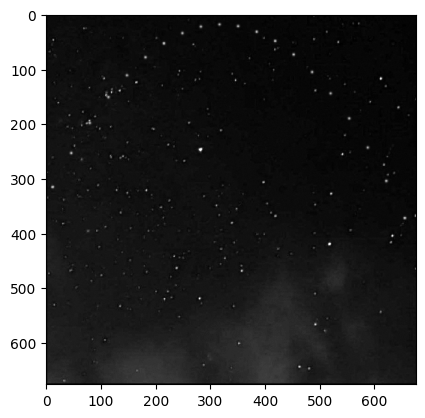

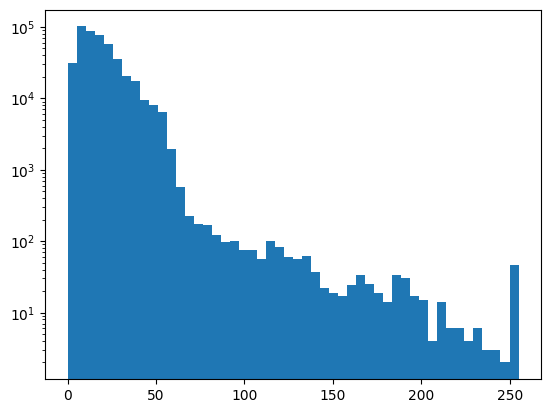

In [3]:
import matplotlib
from matplotlib.pyplot import imshow, show
import matplotlib.pyplot as plt
import numpy as np
import mediapy

raw_color = mediapy.read_image("raw.png")
raw = np.mean(raw_color, axis=2)

imshow(raw, cmap="gray")
show()

fig = plt.figure()
hist = fig.add_subplot(1, 1, 1)
hist.hist(raw.flatten(), 50)
hist.set_yscale('log')

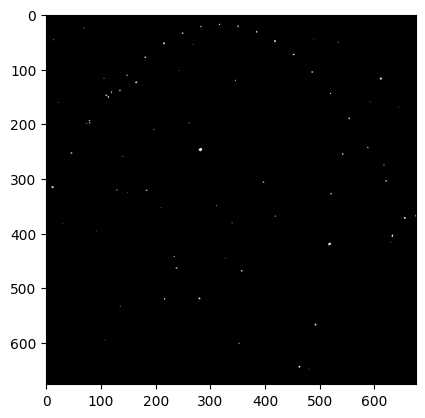

In [4]:


contrasted = np.zeros(raw.shape, dtype=int)
contrasted[raw > 150] = 1

imshow(contrasted, cmap="gray")
show()

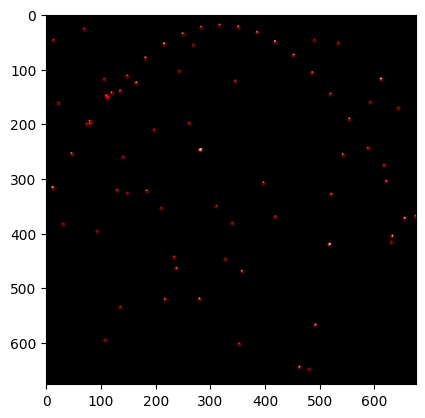

In [5]:

def find_regions(img):

    visited = np.zeros(img.shape)
    neighborhood = [(1,0), (0,1), (-1,0), (0,-1)]
    width, height = img.shape

    def region_grow(startpos):
        todo = [startpos]
        region = []

        while len(todo) > 0:
            pos = todo.pop()
            if img[pos] == 0 or visited[pos] == 1:
                continue

            visited[pos] = 1
            region.append(pos)

            pos_x, pos_y = pos

            for off_x, off_y in neighborhood:
                next_x, next_y = pos_x + off_x, pos_y + off_y
                if next_x >= 0 and next_x < width and \
                    next_y >= 0 and next_y < height:
                    todo.append((next_x, next_y))

        if len(region) == 0:
            return None
        
        avg_x, avg_y = 0, 0
        for x, y in region:
            avg_x += x
            avg_y += y
        avg_x /= len(region)
        avg_y /= len(region)

        return avg_x, avg_y

    centers = []

    for x in range(width):
        for y in range(height):
            center = region_grow((x, y))
            if center != None:
                centers.append(center)
    
    return centers


centers = find_regions(contrasted.T)
# print(centers)

xs = [ x for (x, y) in centers ]
ys = [ y for (x, y) in centers ]

plt.imshow(contrasted * 255, zorder=1, cmap="gray")
plt.scatter(xs, ys, zorder=2, marker='.', linewidths=0.1, c="red", alpha=0.4)
plt.show()


0.0547945205479452
0.0684931506849315
0.0821917808219178
0.1506849315068493
0.2191780821917808
0.2876712328767123


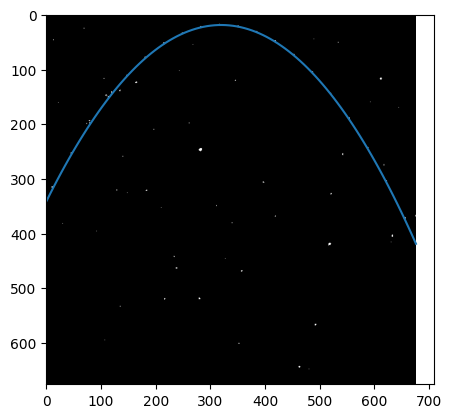

In [6]:

import random


def find_abc(xs, ys):
    A = np.array([
        xs**2,
        xs,
        np.ones(xs.shape)
    ]).T
    sol = np.linalg.lstsq(A, ys, rcond=None)[0]
    return sol

def choose_random_subset(elements, p):
    result = []
    for el in elements:
        if random.uniform(0, 1) < p:
            result.append(el)
    return result

def choose_random_subset_fixed(elements, k):
    temp = elements.copy()
    result = []
    for _ in range(k):
        i = random.randint(0, len(temp) - 1)
        result.append(temp[i])
        temp.pop(i)
    return result

def ransac(N, choose, evaluate):
    bestChoice = None
    best = 0

    for n in range(N):
        # do an iteration
        choice = choose()
        score = evaluate(choice)
        if bestChoice is None or score > best:
            bestChoice = choice
            best = score
            print(best)

    
    return bestChoice


# find best parabola

subset_size = 3
inlier_dist = 5
iterations = 100

def choose_parameters():
    # ss = choose_random_subset(centers, expected_subset_size / len(centers))
    ss = choose_random_subset_fixed(centers, subset_size)
    xs = np.array([ x for (x, y) in ss ])
    ys = np.array([ y for (x, y) in ss ])
    abc = find_abc(xs, ys)
    return abc

def evaluate_parameters(abc):
    inlier_count = 0

    for x, y in centers:
        err = abs(abc[0] * x*x + abc[1] * x + abc[2] - y)
        if err < inlier_dist:
            inlier_count += 1

    # return percentage of inliers as score
    return inlier_count / len(centers)

best_abc = ransac(iterations, choose_parameters, evaluate_parameters)

# plot

def make_parabola(abc):
    height, width = contrasted.shape
    x = np.linspace(0, width, 100)
    y = abc[0] * x**2 + abc[1] * x + abc[2]
    return x, y

px, py = make_parabola(best_abc)


plt.imshow(contrasted * 255, zorder=1, cmap="gray")
plt.plot(px, py, zorder=2)
plt.show()
